In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np

In [ ]:
class MriDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = f'{self.image_dir}/{self.images[index]}'
        mask_path = f'{self.mask_dir}/{self.images[index].replace(".tif", "_mask.tif")}'

        image = np.array(Image.open(img_path).convert("RGB")).transpose((2, 0, 1))
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)
        mask[mask >= 1.] = 1.0
        
        return image, mask

In [ ]:
def get_loaders(train_dir, train_maskdir, val_dir, val_maskdir, batch_size, num_workers=0, pin_memory=True):
    train_ds = MriDataset(train_dir, train_maskdir)
    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)
    val_ds = MriDataset(val_dir, val_maskdir)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader

In [221]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

Architecture inspired by paper https://arxiv.org/abs/1505.04597

- Instead of normal convolutions, we use padding for outputs to keep original shape
- We use Sigmoid function for output to present probability

![unet](./u-net-architecture.png)

In [222]:
class UNet(nn.Module):
   def __init__(self):
       super(UNet, self).__init__()

       # Encoder
       self.encoder1 = nn.Sequential(
           nn.Conv2d(3, 32, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(32),
           nn.ReLU(inplace=True),
           nn.Conv2d(32, 32, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(32),
           nn.ReLU(inplace=True)
       )
       self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder2 = nn.Sequential(
           nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True)
       )
       self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder3 = nn.Sequential(
           nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True)
       )
       self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder4 = nn.Sequential(
           nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True),
           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True)
       )
       self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


       # Bottleneck
       self.bottleneck = nn.Sequential(
           nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
       )

       # Decoder
       self.upconv4 = nn.Sequential(
           nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2)),
           )
       self.decoder4 = nn.Sequential(
           nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.Tanh(),
           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.Tanh()
       )
       self.upconv3 = nn.Sequential(
           nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)),
           )
       self.decoder3 = nn.Sequential(
           nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.upconv2 = nn.Sequential(
           nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2)),
           )
       self.decoder2 = nn.Sequential(
           nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.upconv1 = nn.Sequential(
           nn.ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2)),
           )
       self.decoder1 = nn.Sequential(
           nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.conv = nn.Sequential(
           nn.ConvTranspose2d(32, 1, kernel_size=(1, 1), stride=(1, 1)),
           nn.Sigmoid()
           )

   def forward(self, x):
        #Encoder
       encoder1 = self.encoder1(x)
       encoder2 = self.encoder2(self.pool1(encoder1))
       encoder3 = self.encoder3(self.pool2(encoder2))
       encoder4 = self.encoder4(self.pool3(encoder3))

       # Bottleneck
       bottleneck = self.bottleneck(self.pool4(encoder4))

       #Decoder & Connections
       x = self.upconv4(bottleneck)
       x = torch.cat([x, encoder4], dim=1)
       x = self.decoder4(x)

       x = self.upconv3(x)
       x = torch.cat([x, encoder3], dim=1)
       x = self.decoder3(x)

       x = self.upconv2(x)
       x = torch.cat([x, encoder2], dim=1)
       x = self.decoder2(x)

       x = self.upconv1(x)
       x = torch.cat([x, encoder1], dim=1)
       x = self.decoder1(x)

       x = self.conv(x)

       return x

model = UNet()

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

We decided to use dice loss since huge parts of masks are just black, especially if the tumor was not detected, so normal accuracy wouldn't provide much information since model could just guess no mask on every image

In [223]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 100
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2).sum()

        return 1 - ((2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth))

In [224]:
trainloader_tune, validloader_tune = get_loaders("./tune/img/train", "./tune/mask/train", "./tune/img/val", "./tune/mask/val", 16, num_workers=0)

We tried to compare different optimizers, however results we obtained in this and later part made us believe that we might have done something wrong with counting accuracy, we didn't have enough time to run it multiple times to check if everything is counted correctly

In [225]:
optimizers = [optim.Adam(model.parameters(), lr=0.001), optim.SGD(model.parameters(), lr=0.001), optim.RMSprop(model.parameters(), lr=0.001)]
optim_names = ["Adam", "SGD", "RMSprop"]
epochs = 4

criterion = DiceLoss()

optim_scores = {
    "Adam": [],
    "SGD": [],
    "RMSprop": []
} 

for optim_name, optimizer in zip(optim_names, optimizers):
    model = UNet()

    best_acc = -float('inf')

    for epoch in range(epochs):

        total_train_loss=0
        total_val_loss=0
        model.train()
        total_train_iou = 0.0
        for data, targets in trainloader_tune:
            data, targets = data.float(), targets.float()
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred,targets)
            total_train_loss+=loss.item()
            loss.backward()
            optimizer.step()
        model.eval()

        correct = 0
        pixels = 0
        model.eval()

        with torch.no_grad():
            for data, targets in validloader_tune:
                data, targets = data.float(), targets.float()
                predictions = model(data)
                predictions = (predictions > 0.5).float()
                correct += (predictions[0] == targets).sum()
                pixels += 256 * 256 * len(predictions)
        
        print(f"Optimizer: {optim_name}, Epoch: {epoch+1}/{epochs}, Accuracy: {correct*100/pixels:.2f}")
        optim_scores[optim_name].append(correct/pixels)
        if correct/pixels > best_acc:
            best_acc = correct/pixels
            
    optim_scores[optim_name].append(best_acc)

Optimizer: Adam, Epoch: 1/4, Accuracy: 29.58
Optimizer: Adam, Epoch: 2/4, Accuracy: 31.77
Optimizer: Adam, Epoch: 3/4, Accuracy: 32.00
Optimizer: Adam, Epoch: 4/4, Accuracy: 31.86
Optimizer: SGD, Epoch: 1/4, Accuracy: 24.19
Optimizer: SGD, Epoch: 2/4, Accuracy: 25.90
Optimizer: SGD, Epoch: 3/4, Accuracy: 27.25
Optimizer: SGD, Epoch: 4/4, Accuracy: 26.62
Optimizer: RMSprop, Epoch: 1/4, Accuracy: 75.56
Optimizer: RMSprop, Epoch: 2/4, Accuracy: 70.47
Optimizer: RMSprop, Epoch: 3/4, Accuracy: 70.03
Optimizer: RMSprop, Epoch: 4/4, Accuracy: 70.35


Testing optimizers was done on 1/10 of dataset in order to speed up the process however it still took 45 mins for all 3 models to complete just 4 epochs

In [226]:
learning_rate = 0.001

criterion = DiceLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate)

In [227]:
trainloader, validloader = get_loaders("./data/img/train", "./data/mask/train", "./data/img/val", "./data/mask/val", 32, num_workers=0)

We decided to stick with ADAM optimizer since it's most commonly used and we didn't fully believe results from before. 

Chosen hyperparmeters were mostly restricted by training time and memory, so total number of epochs is set very low and batch size is set as 16 or 32 

In [230]:
model = UNet()
epochs=4

train_loss=[]
val_loss = []

best_dice_score = -float('inf')

train_loop = tqdm(trainloader)

for epoch in range(epochs):

    total_train_loss=0
    total_val_loss=0
    model.train()
    total_train_iou = 0.0
    for data, targets in train_loop:
        data, targets = data.float(), targets.float()
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, targets)
        total_train_loss+=loss.item()
        loss.backward()
        optimizer.step()
    train_loss.append(total_train_loss/(len(trainloader)+1))

    model.eval()

    correct = 0
    pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for data, targets in validloader:
            data, targets = data.float(), targets.float()
            predictions = model(data)
            predictions = (predictions > 0.5).float()
            correct += (predictions[0] == targets).sum()
            pixels += 256 * 256 * len(predictions)
            dice_score += (2 * (predictions[0] * targets).sum()) / ((predictions[0] + targets).sum() + 1e-8)
    
    print(f"Epoch: {epoch+1}/{epochs}, Accuracy: {correct*100/pixels:.2f}, Dice score: {dice_score/len(validloader)}")
    
    if dice_score > best_dice_score:
        print(f'saving best model to unet.pth')
        best_dice_score = dice_score
        torch.save(model.state_dict(), 'unet.pth')


100%|██████████| 188/188 [34:24<00:00, 10.98s/it]


Epoch: 1/4, Accuracy: 38.64, Dice score: 0.026479873806238174
saving best model to unet.pth
Epoch: 2/4, Accuracy: 39.43, Dice score: 0.02675391547381878
saving best model to unet.pth
Epoch: 3/4, Accuracy: 38.99, Dice score: 0.026556989178061485
Epoch: 4/4, Accuracy: 40.15, Dice score: 0.02685188502073288
saving best model to unet.pth


The training took 3hrs, we didn't expect that ammount of time and it kind of ruined our schedule, as stated before we are not sure about measures, however expertiments below show decent results so we kept it this way

In [ ]:
model.load_state_dict(torch.load('unet.pth'))

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
testloader = DataLoader(MriDataset("./data/img/test", "./data/mask/test"), batch_size=1, shuffle=True)

Results we obtained were suprisingly decent especially accounting for accuracy we obtained, but this might be mistake on our part with counting accuracy and dice score itself

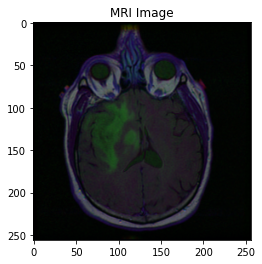

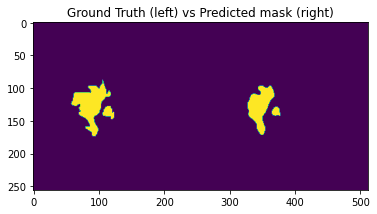

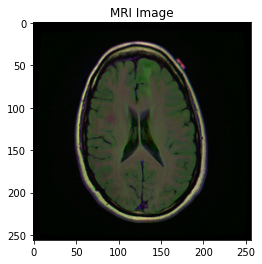

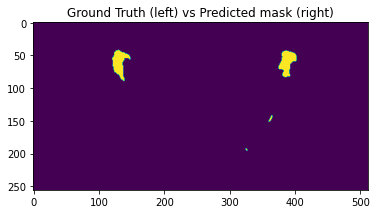

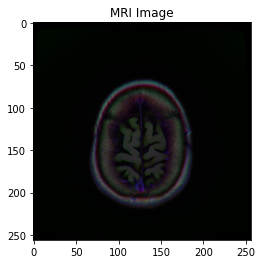

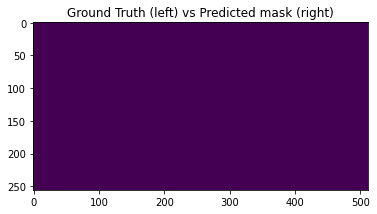

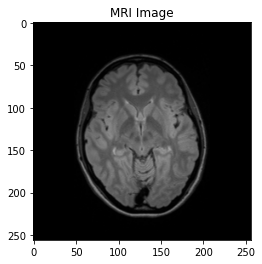

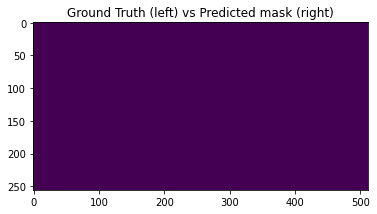

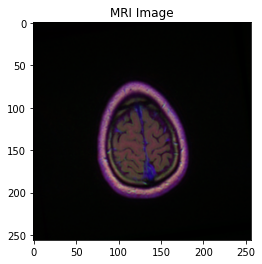

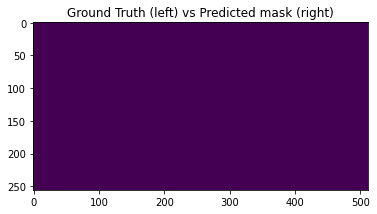

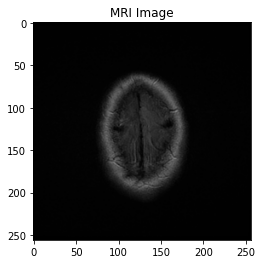

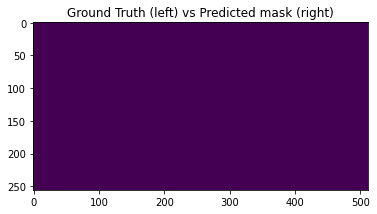

In [ ]:
for i, (image, mask) in enumerate(testloader):
    plt.imshow(image[0].numpy().transpose((1, 2, 0)))
    plt.title("MRI Image")
    plt.show()
    with torch.no_grad():
        image = image.float()
        mask = mask.float()
        predictions = model(image)
        predictions = (predictions > 0.5).float()


        concatenated_image = np.concatenate([mask[0], predictions[0][0].numpy()], axis=1)

        # Display the concatenated image
        plt.imshow(concatenated_image)
        plt.title("Ground Truth (left) vs Predicted mask (right)")
        plt.show()
    if i == 5:
        break

Criterion|Points
---|---
problem: segmentation | 1
10 000 images | 1
6000 > own images | 1
model: own architecture | 2
augmentation | 1
DVC | 2
Total | 8